In [10]:
%reset -f
import pandas as pd
import numpy as np
seed = 2018
np.random.seed(seed)
from wavhandler import *
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import math
import warnings
from utils_train import *
from keras.applications.densenet import DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.utils import np_utils

# sns.set()
%matplotlib inline

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


# Loading data

In [11]:
current_model = DenseNet121

setting = 'stft'
if setting in ['gasf','gadf', 'mtf', 'rp']:
    input_shape = (150,150,1)
elif setting=='stft':
    input_shape = (129, 120, 1)

model_name = 'LG' + '_' + setting + '_' + current_model.__name__
top_weights_path = TEMP_DATADIR + 'model_' + str(model_name) + '.h5'
logfile = TEMP_DATADIR + 'model_' + str(model_name) + '.log'

batch_size = 32
monitor = 'val_acc'
es_patience = 7
rlr_patience = 3

In [12]:
# data1 = Dataset('increasing dataset')
# data1.target_classes = [i for i in data1.target_classes if "aedes" not in i.split('_')]
# data1.load(only_names=True, text_labels=True)
# data2 = Dataset('Wingbeats')
# data2.load(only_names=True, nr_signals=5000, text_labels=True);
data = Dataset('LG')
data.load(only_names=True, text_labels=True);

100%|██████████| 2/2 [00:00<00:00, 33.05it/s]


In [13]:
X_names = data.filenames
y = data.y
target_names = np.unique(y)
print("Names of all classes: \n{}".format(target_names))
print(pd.Series(y).value_counts())

Names of all classes: 
['LG_drosophila_10_09' 'LG_zapr_26_09']
LG_zapr_26_09          7210
LG_drosophila_10_09    5536
dtype: int64


# Splitting into Train/Val/Test

In [14]:
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_names, y, 
                                                    test_size=0.10, 
                                                    shuffle=True, 
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=0)
print("Train shape: \t{}, \nTest shape: \t{}, \nValid shape: \t{}".format(len(X_train), len(X_test), len(X_val)))

Train shape: 	9176, 
Test shape: 	1275, 
Valid shape: 	2295


In [6]:
callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = True),
    EarlyStopping(monitor = 'val_acc', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger(logfile)]

img_input = Input(shape = input_shape)

model = current_model(input_tensor = img_input, classes = len(target_names), weights = None)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks_list = [ModelCheckpoint(monitor = monitor,
                                filepath = top_weights_path,
                                save_best_only = True,
                                save_weights_only = True,
                                verbose = 1),
                    EarlyStopping(monitor = monitor,
                                patience = es_patience,
                                verbose = 1),
                    ReduceLROnPlateau(monitor = monitor,
                                factor = 0.1,
                                patience = rlr_patience,
                                verbose = 1),
                    CSVLogger(filename = logfile)]

In [7]:
model.fit_generator(train_generator(X_train,
                                    y_train, 
                                    batch_size=batch_size, 
                                    target_names=target_names,
                                    setting=setting),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
                    epochs=100, 
                    validation_data = valid_generator(X_val,
                                                      y_val, 
                                                      batch_size=batch_size, 
                                                      target_names=target_names,
                                                      setting=setting), 
                    validation_steps = int(math.ceil(float(len(X_test)) / float(batch_size))),
                    callbacks = callbacks_list)

Epoch 1/100
131/287 [============>.................] - ETA: 1:47 - loss: 0.1423 - acc: 0.9444

KeyboardInterrupt: 

In [9]:
model.load_weights(top_weights_path)

loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                     y_test, 
                                                     batch_size=batch_size, 
                                                     setting=setting, 
                                                     target_names=target_names),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))
#print('loss', loss)
print('Test accuracy:', acc)

Test accuracy: 0.9984313725490196


In [8]:
from keras.models import model_from_yaml
# serialize model to YAML
model_yaml = model.to_yaml()
with open(TEMP_DATADIR + model_name + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights(TEMP_DATADIR + model_name + "_weights.h5")

In [108]:
sns.reset_orig()

100%|██████████| 2/2 [00:00<00:00, 38.80it/s]


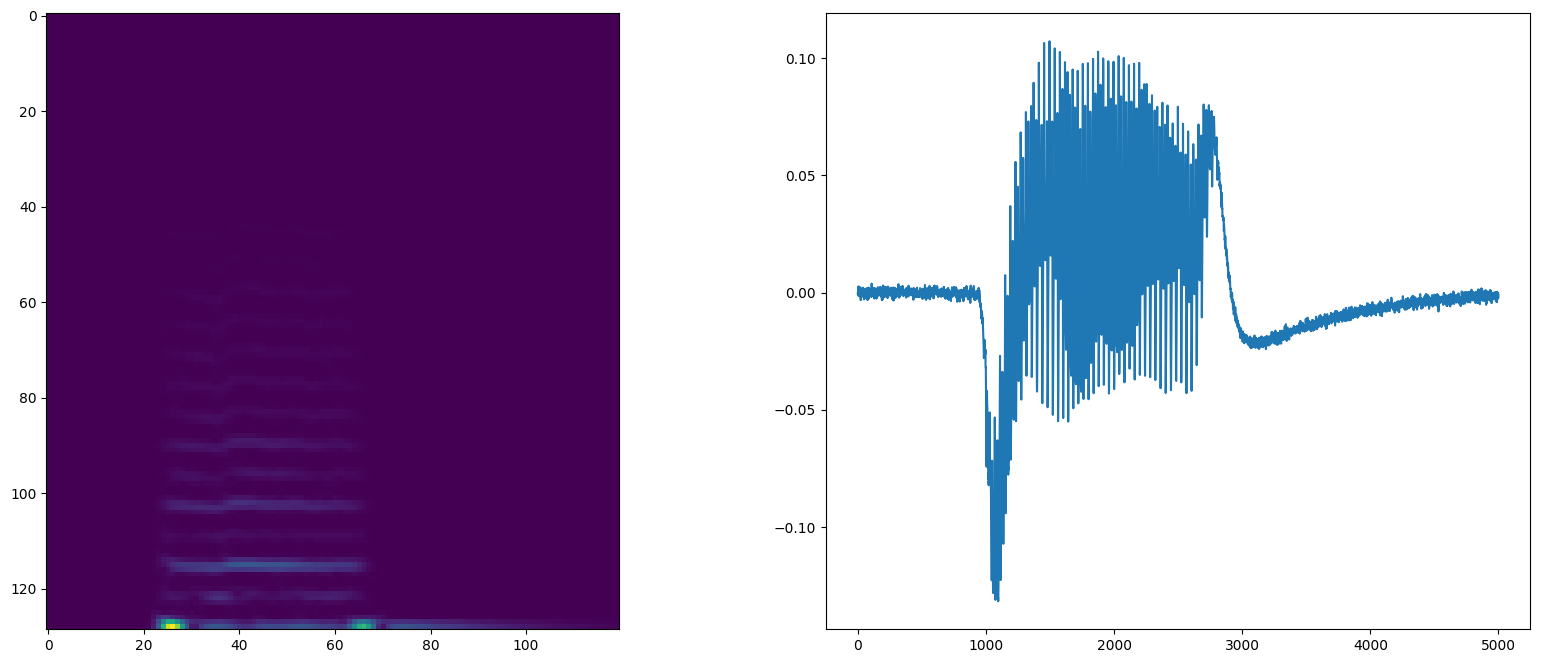

In [111]:

z = data.load(nr_signals=1)[0][23+46]
import librosa
zz = librosa.stft(z, n_fft = N_FFT, hop_length = HOP_LEN)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(np.flipud(np.abs(zz)))
plt.grid(False)
plt.subplot(1,2,2)
plt.plot(z)
plt.grid(False)
i+=1

In [88]:
i

33

In [102]:
i

46